# Data Exploration: Distributions and Outliers

Aim of this script is to check if datasets used in the project include any unusual observations and to understand why some of the records look suspicious.

Table of contents:
1. [Hourly number of bike rentals](#Distribution-of-Hourly-Number-of-Rentals)
2. [Daily number of bike rentals](#Distribution-of-Daily-Number-of-Rentals)
3. [Rides from A to A](#Stations-Data:-Rides-from-point-A-to-point-A)
4. [Bike rental duration](#Distribution-of-Bike-Rental-Duration)
5. [Daily number of short rides](#Distribution-of-Daily-Number-of-Short-Rides)
6. [Distance of rides](#Distribution-of-Distance)
7. [Weather data](#Check-correctness-of-weather-data)

In [ ]:
import os
os.chdir('..')

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from scipy import stats
from collections import Counter

import functions as f

plt.style.use('ggplot')
sns.set()
pd.set_option('display.float_format', '{:.2f}'.format)
register_matplotlib_converters()

In [2]:
df = pd.read_parquet('data/db_rentals.parquet')
df_distance = pd.read_parquet('data/db_stations_distance.parquet')
df_weather = pd.read_parquet('data/db_weather.parquet')

C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In order to limit size of the dataset, the main focus will be on bike rentals from Washington D.C.

In the first step, the dataset is prepared and records containing information about rentals are merged with the distance between start and end station. Having this information and data about rental duration, the speed is calculated. It is far-reaching estimation since we don't have exact information about the route (only distance in a straight line) and about potential stops. Nevertheless, this calculation may be useful to give some overview about the speed and to check which distances are more or less accurate.

In further steps, speed and distance values will be removed from records when those calculations don't apply.

In [3]:
df = df[(df['city']=='D.C.')&(df['member_type'].isin(['Member', 'Casual']))].reset_index(drop=True)
df = df.merge(df_distance, how='left', left_on=['start_station_id', 'end_station_id'], right_on=['station_a', 'station_b'])

drop_cols = [c for c in df.columns if '_a' in c or '_b' in c]
df = df.drop(drop_cols, axis=1)
df['speed'] = df['distance'] / (df['duration']/3600)

In [4]:
df_byHour = f.round_byTime(df, 'H')

## Distribution of Hourly Number of Rentals

Usually number of bike rentals in an hour ranges from 46 and 413, with median equal to 187. The distribution is positively skewed with some outliers (but not very distant ones). Probably those are the numbers achieved during special holidays or weekend with especially pleasant weather.

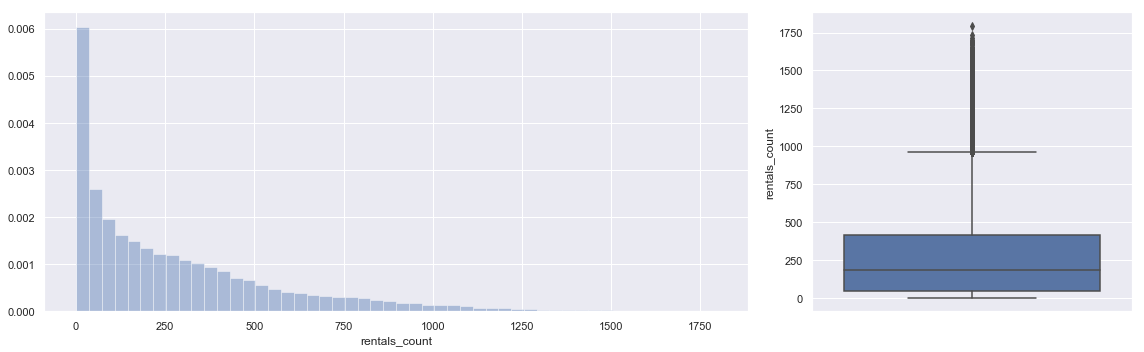

0.25 quantile:  48.0
0.5 quantile:  187.0
0.75 quantile:  413.0
0.95 quantile:  885.0
0.99 quantile:  1212.0
max value: 1793


In [7]:
f.distribution_check(df_byHour, 'rentals_count')

## Distribution of Daily Number of Rentals

Number of daily bike rentals has a shape of multimodal distribution. It seems that there are two underlying distributions eg. one for Member and one for Casual users or one for summer and one for cold months.
There aren't any visible outliers.

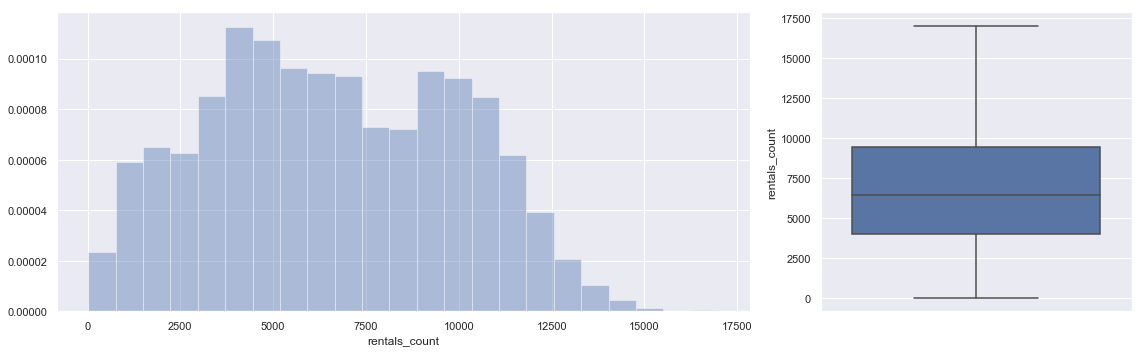

0.25 quantile:  3987.25
0.5 quantile:  6455.5
0.75 quantile:  9458.0
0.95 quantile:  11988.199999999999
0.99 quantile:  13396.42
max value: 16985


In [9]:
df_byDay = f.round_byTime(df, 'D')
f.distribution_check(df_byDay, 'rentals_count')

## Stations Data: Rides from point A to point A

Rides from and to the same point are something that require closer look. There are possible reasons of such records in data:
- round trip - user rented a bike in point A, took a ride and returned in in the same station
- unexpected behaviour - user rented a bike and a problem occured: issue with the app or bike, user wanted just to check the service

Evaluation of the above scenarios can be done based on duration of bike rental. Anyway, in both cases, calculating distance & speed is pointless so for those records it shouldn't contain any value.

Important note from data provider Capital Bike Share:

_This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations at our warehouses and any trips lasting less than 60 seconds (potentially false starts or users trying to re-dock a bike to ensure it's secure)._

Things to check in order to evaluate if bike rental was affected by any technical issue:
- check rides from point A to point A that are shorter than 5 minutes (in the script they will be marked as _tricky_)
- if those rides were affected by service downtime we should see increase of this kind of rides in particular day / hour (check hourly ratio of tricky rides / all rides)

In [12]:
df_tricky = df.loc[np.where((df['start_station_id']==df['end_station_id']) & (df['duration']<600))].reset_index(drop=True)
df_tricky_byHour = f.round_byTime(df_tricky, 'H')

df_byHour = df_byHour.merge(df_tricky_byHour, how='left', on='start_date', suffixes=['_total', '_tricky'])
df_byHour['tricky_ratio'] = df_byHour['rentals_count_tricky'] / df_byHour['rentals_count_total']

### Distribution of Hourly Ratio: Tricky vs Total

Chart below shows that any ratio of tricky vs total rides above 0.1 looks suspicious. Apparently there are several hours when this case occured.

To examine this, let's take a closer look - hours with high tricky ratio are the ones when total number of rides was low too. In such case, calculated ratio doesn't seem significant since even low number of tricky rides can visibly increase tricky ratio (so high tricky ratio may be achieved by chance).

At the same time, it's good to check what is the reason of low number of total rides in an hour - in all cases those are the hours at night, between 0-5 so it's completly justified.

When we take a look at the distribution of tricky ratio in hours with at least 100 rides, the distribution looks much more regular.

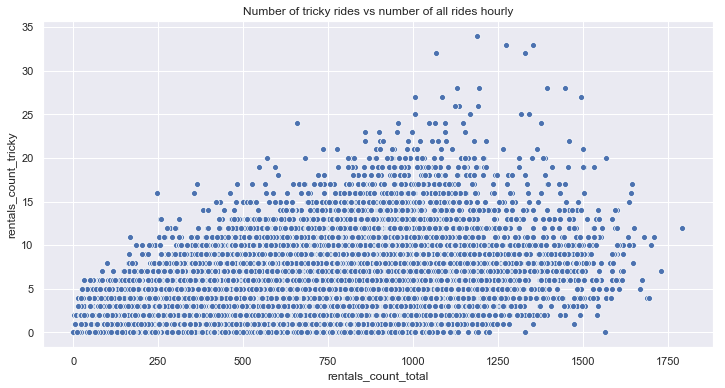

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot('rentals_count_total', 'rentals_count_tricky', data=df_byHour)
ax.set_title('Number of tricky rides vs number of all rides hourly')
plt.show()

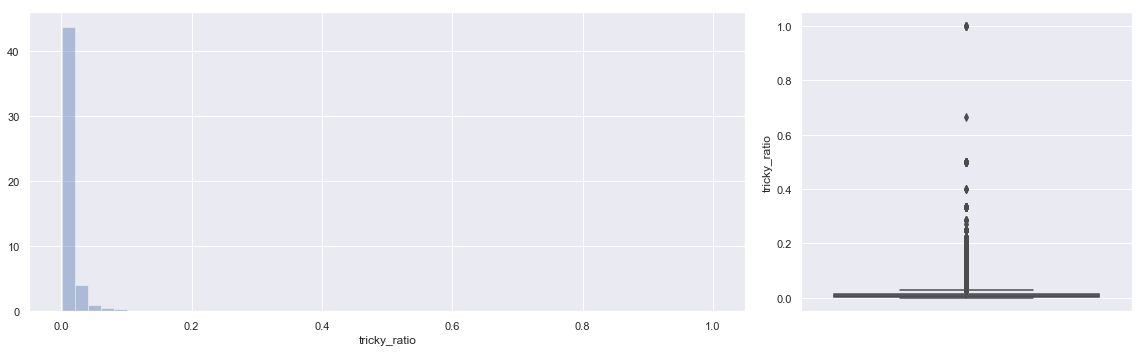

In [11]:
distribution_check(df_byHour, 'tricky_ratio')

In [22]:
df_byHour_trickyHours = df_byHour[df_byHour['tricky_ratio']>0.1]

print('Average number of bike rentals in one hour:', df_byHour['rentals_count_total'].mean())
print('Average number of bike rentals in one hour with high \'tricky\' ratio:', df_byHour_trickyHours['rentals_count_total'].mean())
print('Maximum number of bike rentals in one hour with high \'tricky\' ratio:', df_byHour_trickyHours['rentals_count_total'].max())

Average number of bike rentals in one hour: 275.8176069184515
Average number of bike rentals in one hour with high 'tricky' ratio: 9.083160083160083
Maximum number of bike rentals in one hour with high 'tricky' ratio: 59


In [33]:
print('Around 89% of rides with high \'tricky\' ratio are between 0am and 5am')

Around 89% of rides with high 'tricky' ratio are between 0am and 5am


In [34]:
df_trickyHours_cumsum = df_byHour_trickyHours['start_date'].dt.hour.value_counts(normalize=True).cumsum().head(6)
pd.DataFrame({'hour': df_trickyHours_cumsum.index, 'cumulative share': df_trickyHours_cumsum})

,hour,cumulative share
3,3,0.26
2,2,0.49
4,4,0.65
1,1,0.79
5,5,0.86
0,0,0.89


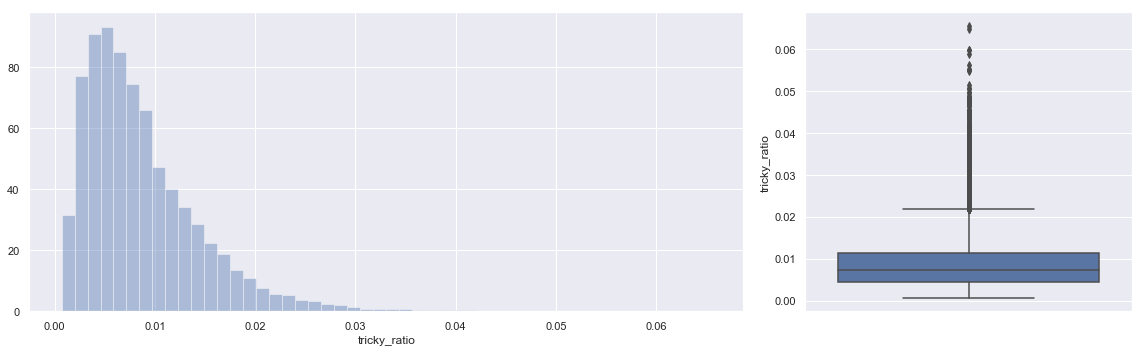

0.25 quantile:  0.004484304932735426
0.5 quantile:  0.007282816241172727
0.75 quantile:  0.011413082419765632
0.95 quantile:  0.01995040115896509
0.99 quantile:  0.02912621359223301
max value: 0.06547619047619048


In [44]:
f.distribution_check(df_byHour[df_byHour['rentals_count_total']>100], 'tricky_ratio')

## Distribution of Bike Rental Duration

At first glance it seems that there are some very distance outliers in the data. The first question that occurs is: 'Are those records correct?'. It's important to notice that maximum duration of bike rental is 86,381 milliseconds which is equal to almost 24 hours - it is also the longest plan offered by the company.

Since all those records seem reasonable, let's imagine two different user's behaviours:
1. user rents a bike to quickly move from point A to point B
2. user rents a bike for a trip - it includes stops or maybe even keeping the bike for the night

Those two kinds of behaviours should be visible in data and in order to find the contractual border between them, let's calculate z-score and IQR and see which of them works better.

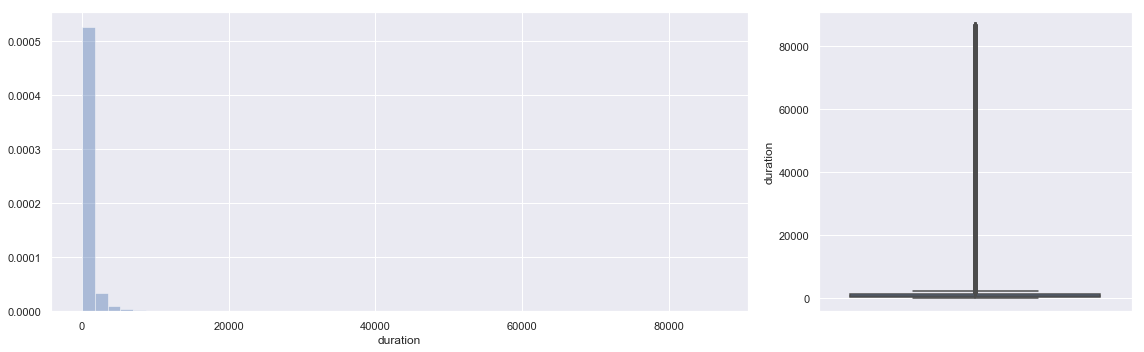

0.25 quantile:  408.0
0.5 quantile:  675.0
0.75 quantile:  1112.0
0.95 quantile:  2626.0
0.99 quantile:  6992.0
max value: 86381


In [36]:
f.distribution_check(df, 'duration')

In [37]:
print('\nmean in minutes:', df['duration'].mean()/60)
print('median in minutes:', df['duration'].median()/60)
print('max in hours:', df['duration'].max()/3600)


mean in minutes: 18.376458028221013
median in minutes: 11.466666666666667
max in hours: 23.994722222222222


In [38]:
# Calculate upper bound with zscore method and IQR
q1 = df['duration'].quantile(0.25)
q3 = df['duration'].quantile(0.75)

upper_iqr = q3 + 1.5 * (q3 - q1)
upper_z = df['duration'].mean() + 3*df['duration'].std()

print('upper bound IQR (minutes):', upper_iqr/60)
print('upper bound z-score (minutes):', upper_z/60)

upper bound IQR (minutes): 37.725
upper bound z-score (minutes): 120.67706943093596


For a purpose of finding the boundary between normal and long rides, z-score looks more appropriate. Rides shorter than 120 minutes will include all direct rides from A to B and short trips. Records longer than 2 hours will be classified as long rides.

In this case, instead of removing extraordinary records, they will be labeled as 'normal' and 'long'. This way, not only is data deletion avoided but also new feature is created. After division, we can see that duration distribution is still skewed but it has more regular shape.

At the same time, calculating speed and distance for long rides is pointless so let's remove those values for this group.

In [39]:
df['ride_length'] = 'normal'
df.loc[df['duration']>upper_z, 'ride_length'] = 'long'

distribution for normal rides, 0.987210 share in rides


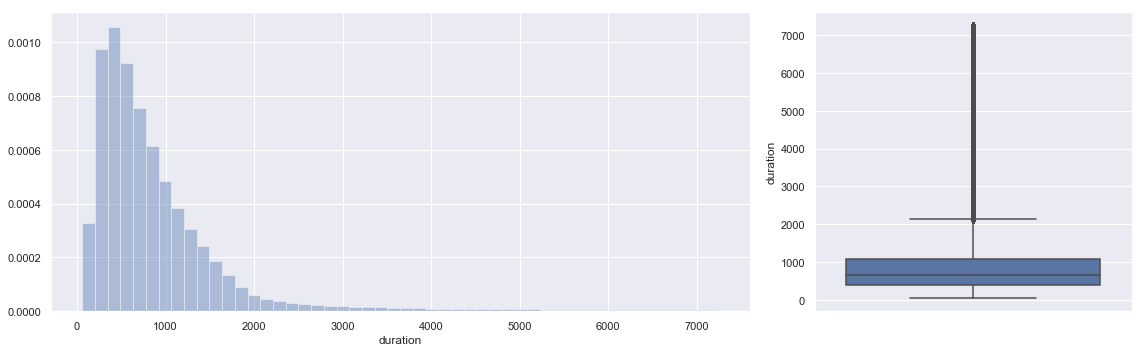

0.25 quantile:  405.0
0.5 quantile:  669.0
0.75 quantile:  1095.0
0.95 quantile:  2325.0
0.99 quantile:  5080.0
max value: 7240


In [41]:
df_normalLength = df[df['ride_length']=='normal']
print('distribution for normal rides, %f share in rides' % (len(df_normalLength)/ len(df)))
f.distribution_check(df_normalLength, 'duration')

distribution for long rides, 0.012790 share in rides


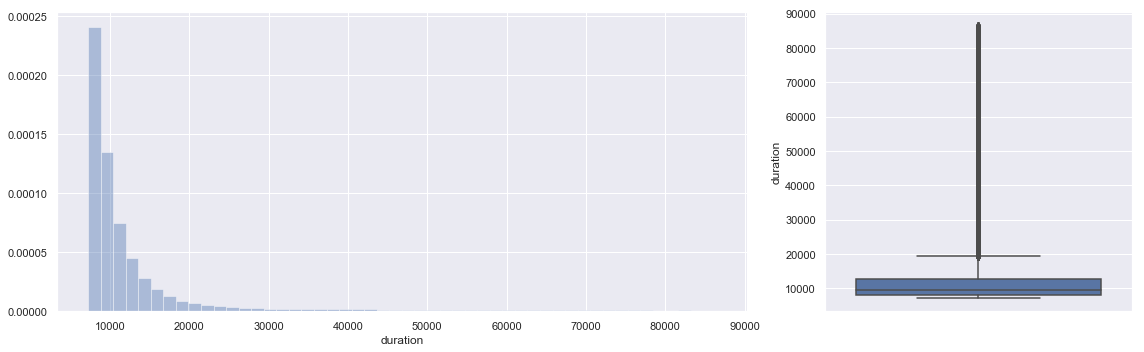

0.25 quantile:  8167.0
0.5 quantile:  9587.0
0.75 quantile:  12688.0
0.95 quantile:  37247.79999999993
0.99 quantile:  71910.53999999998
max value: 86381


In [42]:
df_longLength = df[df['ride_length']=='long']
print('distribution for long rides, %f share in rides' % (len(df_longLength)/ len(df)))
f.distribution_check(df_longLength, 'duration')

In [43]:
df.loc[df['ride_length']=='long', ['distance', 'speed']] = np.nan

## Distribution of Daily Number of Short Rides

Days with high number of short rides (shorter than 5 minutes) could be a signal that there was a downtime on a particular day. Fortunately, the distribution is very regular without any outliers.

In [46]:
#df_byDay = round_byTime(df, 'D')
df_byDay_short = f.round_byTime(df[df['duration']<600], 'D')

In [47]:
df_byDay_short = df_byDay.merge(df_byDay_short, on='start_date', how='left', suffixes=('_total', '_short'))
df_byDay_short['short_ratio'] = df_byDay_short['rentals_count_short'] / df_byDay_short['rentals_count_total']

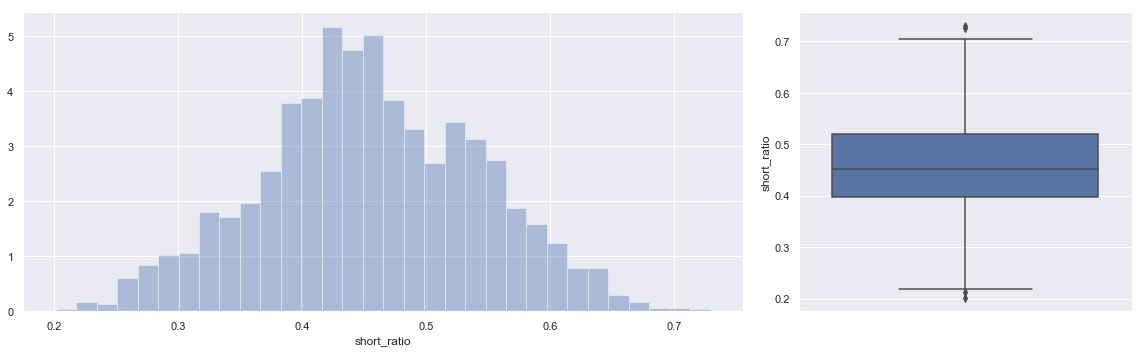

0.25 quantile:  0.396796878939971
0.5 quantile:  0.45173644011829905
0.75 quantile:  0.5201347766998052
0.95 quantile:  0.6017381841423621
0.99 quantile:  0.6482369985398881
max value: 0.7296511627906976


In [48]:
f.distribution_check(df_byDay_short, 'short_ratio')

## Distribution of Distance

Usually distance of bike trip ranges from 0 and 40km, with median equal to 8.9km. The distribution is positively skewed with some outliers (but not very distant ones).

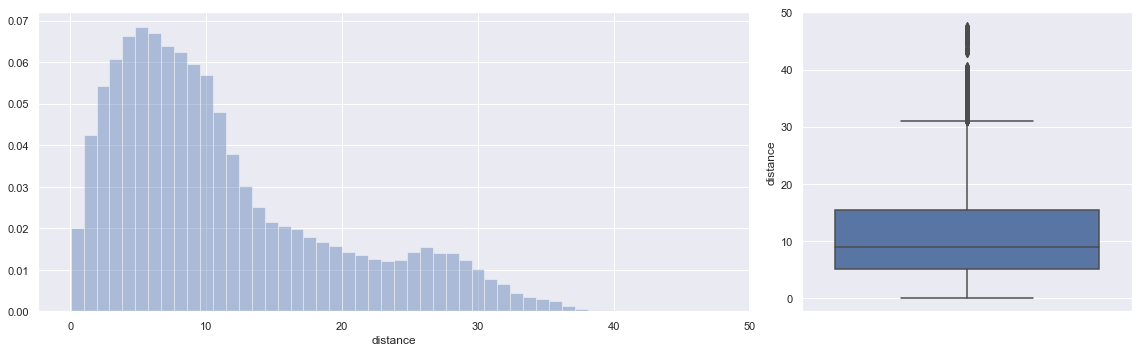

0.25 quantile:  5.055259685952393
0.5 quantile:  8.914708010072644
0.75 quantile:  15.415684443482792
0.95 quantile:  28.63646808862423
0.99 quantile:  33.63417663662545
max value: 47.63502560676512


In [49]:
f.distribution_check(df_distance, 'distance')

## Rides with too short duration compared to distance

Since ride distance is a new metric calculated from (possibly not up-to-date) data, it can be verified by comparing it with duration. By calculating so called speed it can be checked which records are suspicious.

The chart below shows that majority of rides is with speed less than 30 km/h but there are some outliers. Since data provider claims that all technical rides were removed, it seems that the main explanation could be the fact that information about station's location was not correct for the time of bike ride. Because of this it's good to check if:
- are there any stations that characterize with rides of high speed?
- is there any point in time when the speed from / to particular station looks unusual?

The easiest solution would be to remove all records with high speed but it wouldn't solve the entire problem - there still would be stations with incorrect location for a given time (it was just not visible in speed). The action plan is to:
1. Confirm if high speed may be due to changed station's location
2. Define stations with incorrect location (and time of change if possible)
3. Remove all distance and speed records from these stations

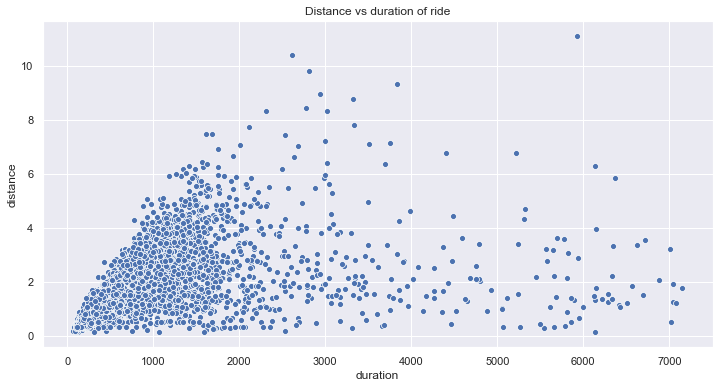

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot('duration', 'distance', data=df.sample(5000))
ax.set_title('Distance vs duration of ride')
plt.show()

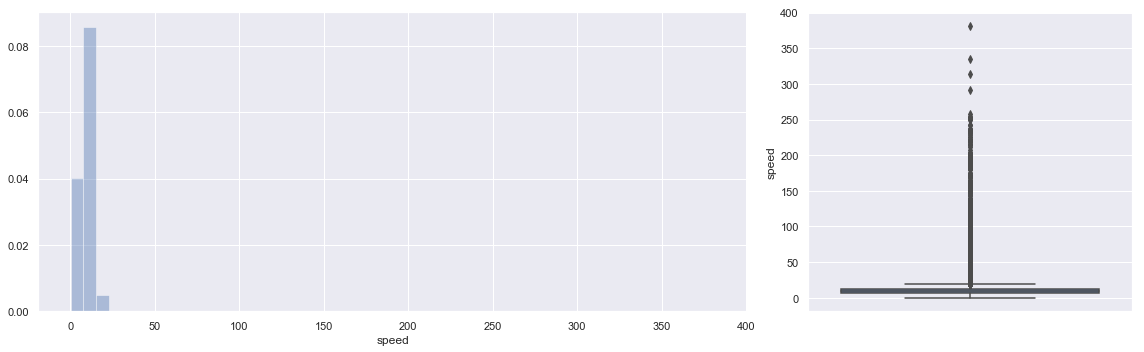

0.25 quantile:  6.974900035737272
0.5 quantile:  9.454840859821239
0.75 quantile:  11.627267609360628
0.95 quantile:  14.866888112536767
0.99 quantile:  17.40427231068553
max value: 381.29565089894135


In [54]:
f.distribution_check(df, 'speed')

In [60]:
def filter_by_first_station(df, selected_station):
    df_selectedStation = df[(df['start_station_id']==selected_station) | (df['end_station_id']==selected_station)].copy().reset_index()
    return(df_selectedStation)

def find_second_station(df, selected_station):
    second_station = np.select(
        [
            df['start_station_id'] == selected_station, 
            df['start_station_id'] != selected_station
        ], 
        [
            df['end_station_id'], 
            df['start_station_id']
        ]
    )
    return(second_station)

def check_station_speed(df, selected_station, verbose=True):
    df_selectedStation = filter_by_first_station(df, selected_station)
    
    if not verbose:
        print('Station responsible for rides share:', len(df_selectedStation)*100/len(df), '%')
    
    df_selectedStation['second_station'] = find_second_station(df_selectedStation, selected_station)
    df_selectedStation = df_selectedStation.groupby([pd.Grouper(key='start_date', freq='M'), 'second_station']).agg({'speed': 'max'}).reset_index()

    fig, ax = plt.subplots(figsize=(16, 8))
    palette = sns.husl_palette(10, h=.5)

    sns.scatterplot(x='start_date', y='speed', hue='second_station', data=df_selectedStation) #, legend='full'
    ax.set(xlim = (df_selectedStation['start_date'].min(), df_selectedStation['start_date'].max()))
    ax.set_title(selected_station)

    plt.show()

### Action plan

It would be the best if one could find perfect solution to obtain 100% reliable data. On the other hand, usually such solutions are time consuming so it's good to be aware if the gain that we can get is worth it.

When it comes to stations with incorrect location, it's not a quick shot to find them. At the same time, rides that are visibly affected by incorrect location constitute only 0.01% of all rides. Because of that, this is an action plan to deal with the problem in relatively quick manner:

1. stations with incorrect location that are easy to find will be removed manually
2. the most popular stations that are responsible for 20% of all rides will be checked manually
3. in the end, for all rides with visibly incorrect location the distance and speed will be removed

In [56]:
def show_speedy_stations(df, max_speed=25, station_type='start'):
    station_type = 'start_station_id'
    if station_type == 'end':
        station_type = 'end_station_id'
    
    speedy_stations = df[df['speed']>max_speed] \
                    .groupby(station_type) \
                    .agg({'rental_id': 'count'}) \
                    .reset_index() \
                    .sort_values(by='rental_id', ascending=False)\
                    .reset_index(drop=True)
    
    speedy_rides_count = speedy_stations['rental_id'].sum()
    print('Number of \'speedy\' stations:', len(speedy_stations))
    print('Number of \'speedy\' rides:', speedy_rides_count)
    print('Share of \'speedy\' rides in total:', speedy_rides_count*100/len(df),'%\n')
    print(speedy_stations.head())

def remove_station_rides(df, station_id, min_date='1990-01-01'):
    df.loc[(df['start_station_id']==station_id) | (df['end_station_id']==station_id) & (df['start_date']<min_date), ['distance', 'speed']] = np.nan
    return df

In [57]:
show_speedy_stations(df)

Number of 'speedy' stations: 171
Number of 'speedy' rides: 2678
Share of 'speedy' rides in total: 0.01311980933458267 %

   start_station_id  rental_id
0             31064        476
1             31062        292
2             31207        191
3             31303        144
4             31300        137


Station 32006 is one of the examples of the station that was moved in certain point of time - till September 2013 rides from this stations had very high speed which means that the station was placed in other location that recorded in data. Starting from September 2013, speed records look correct.

On the other hand, station 31076 looks like a correct station that has rides with high speed but they are due to the fact that the other station (XXX in this case) has incorrect location.

Station responsible for rides share: 0.010170546743313526 %


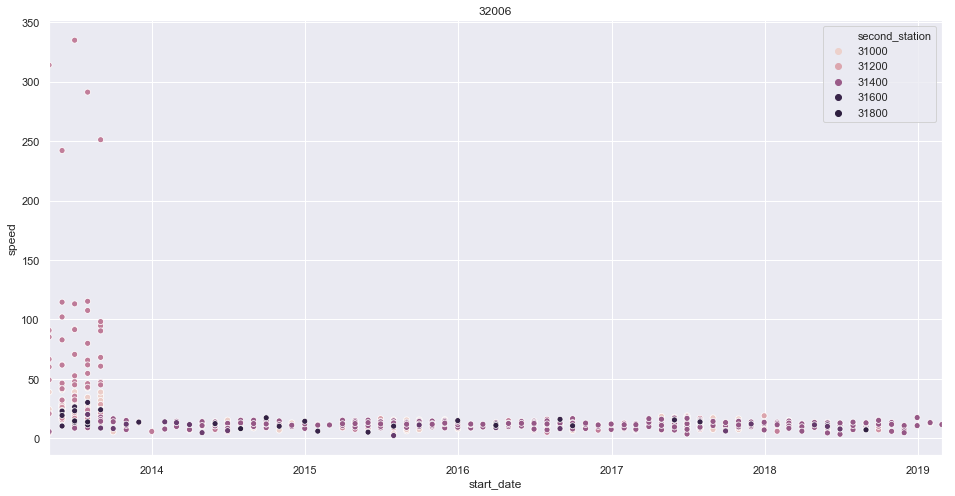

In [61]:
check_station_speed(df, 32006, verbose=False)

Station responsible for rides share: 0.0034195768915379777 %


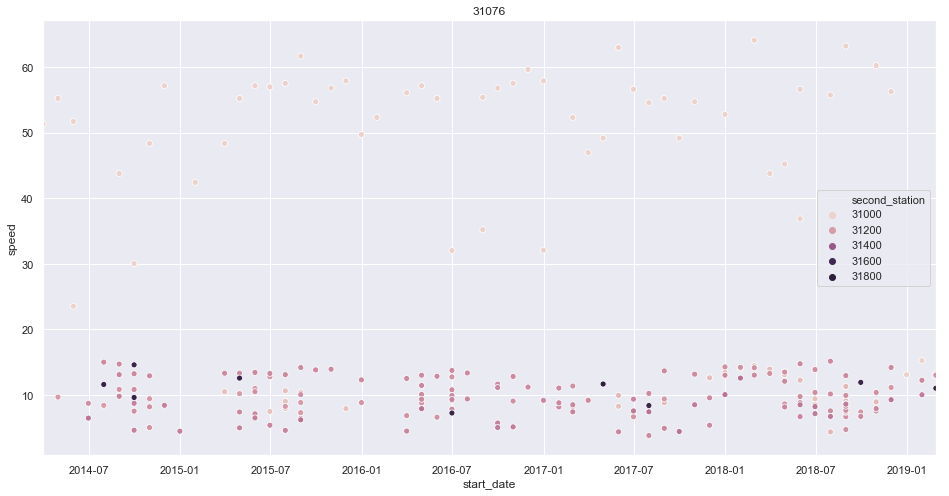

In [62]:
check_station_speed(df, 31076, verbose=False)

In [63]:
# Remove distance and speed for stations that were found manually
df = remove_station_rides(df, 31064)
df = remove_station_rides(df, 31062)
df = remove_station_rides(df, 31062, '2013-09-01')
df = remove_station_rides(df, 31262, '2013-01-01')
df = remove_station_rides(df, 32006, '2013-09-01')
df = remove_station_rides(df, 31052, '2012-01-01')
df = remove_station_rides(df, 31266, '2013-01-01')

Capital Bike Share informs sometimes about changing stations' location for particular day (days) due to some extraordinary events. When checking number of 'speedy' rides per day, we can see that there are several days when this number is unusually high. For all rides from these days, distance and speed will be removed.

In [64]:
speedy_dates = df[df['speed']>25] \
            .groupby(pd.Grouper(key='start_date', freq='D')) \
            .agg({'rental_id': 'count'}) \
            .reset_index() \
            .sort_values(by='rental_id', ascending=False)

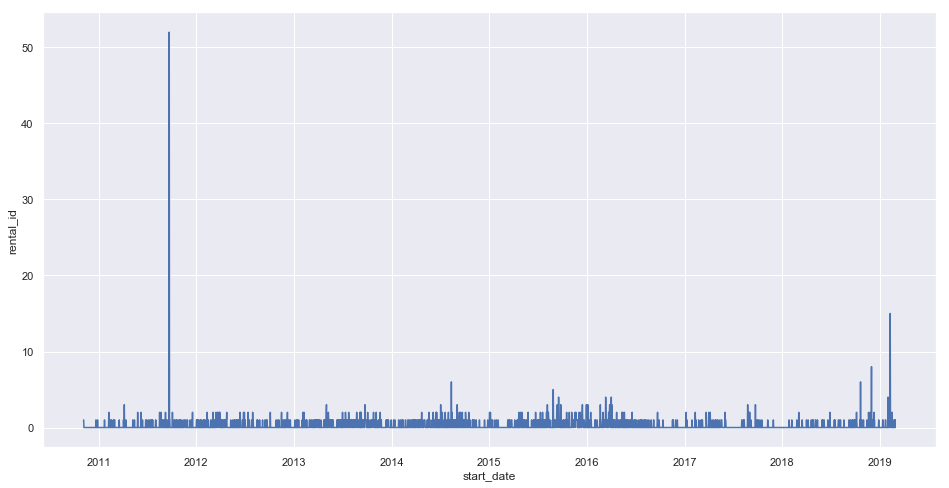

In [65]:
fig, ax = plt.subplots(figsize=(16, 8))
palette = sns.husl_palette(10, h=.5)

sns.lineplot(x='start_date', y='rental_id', data=speedy_dates)
plt.show()

In [66]:
# Remove distance and speed for particular days
dates = np.array(speedy_dates[speedy_dates['rental_id']>10]['start_date'].values, dtype='datetime64[D]')
df['date'] = df['start_date'].dt.date
df.loc[df['date'].isin(dates), ['distance', 'speed']] = np.nan

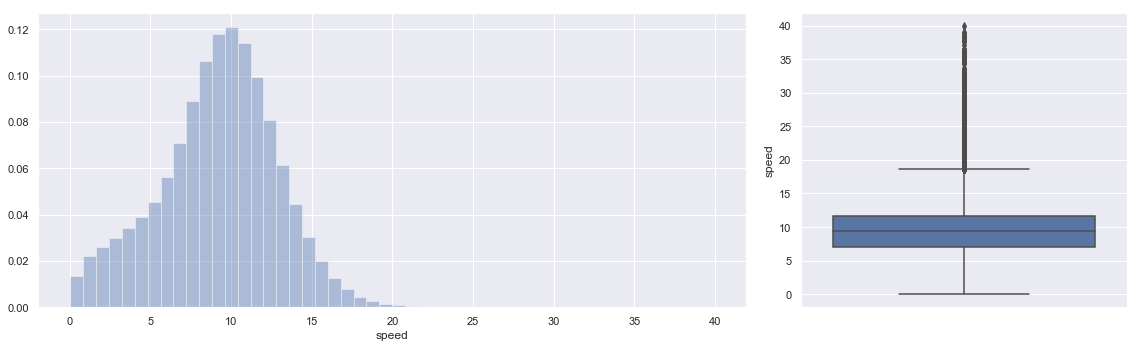

0.25 quantile:  6.971074197201125
0.5 quantile:  9.456674641149494
0.75 quantile:  11.629507645686045
0.95 quantile:  14.86569925093095
0.99 quantile:  17.3883309827061
max value: 39.93352422247173


In [68]:
# Remove distance and speed for all rides where speed is higher than 40 km/h
df.loc[df['speed']>40, ['distance', 'speed']] = np.nan
f.distribution_check(df, 'speed')

## Check correctness of weather data

Verification of distribution of temperatures, humidity, pressure etc.

In [69]:
df_weather = pd.read_parquet('data/db_weather.parquet')

C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [71]:
df_weather.sample(5)

,datetime,date,time,temperature,relative_temperature,wind,relative_humidity,pressure,clouds,rain,snow,thunder
4678,2011-03-16 20:52:00,2011-03-16,20:52,12,12,310,0.54,1020,cloudy,0,0,0
10623,2011-11-22 10:02:00,2011-11-22,10:02,11,11,0,0.94,1024,cloudy,0,0,0
70116,2017-10-21 15:52:00,2017-10-21,15:52,25,24,180,0.30,1026,cloudy,0,0,0
646,2010-09-27 23:52:00,2010-09-27,23:52,22,23,160,0.94,1008,cloudy,0,0,0
80645,2018-09-24 11:52:00,2018-09-24,11:52,19,19,60,0.88,1027,cloudy,1,0,0


## Distribution of temperature

Temperatures range from almost -20 to over +40 Celcius degrees. While temperatures around 40 degrees are rare but possible, record with almost 50 degrees looks like an error. In order to verify this, let's check all temperatures higher than 40 degrees.

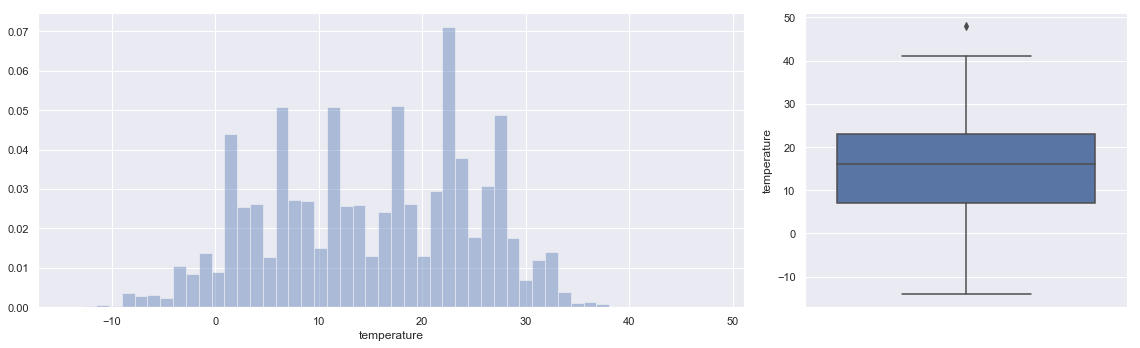

0.25 quantile:  7.0
0.5 quantile:  16.0
0.75 quantile:  23.0
0.95 quantile:  29.0
0.99 quantile:  33.0
max value: 48


In [73]:
f.distribution_check(df_weather, 'temperature')

There are two records with temperature higher than 40 degrees. 48 degrees in December is an obvious outlier so it will be removed. 41 degrees in July is possible and it looks like correct record since in other hours the same day recorded temperatures are at the similar level.

In [74]:
df_weather[df_weather['temperature']>40]

,datetime,date,time,temperature,relative_temperature,wind,relative_humidity,pressure,clouds,rain,snow,thunder
16028,2012-07-07 16:52:00,2012-07-07,16:52,41,40,260,0.19,1010,cloudy,0,0,0
50039,2015-12-16 09:52:00,2015-12-16,09:52,48,44,0,0.07,1020,partly cloudy,0,0,0


In [75]:
df_weather = df_weather[df_weather['temperature']<45]

## Distribution of wind speed

Distribution graph shows that majority of wind speed records is below 400 km/h, however there are some very distant outliers. Since the highest wind speed ever noted was 408 km/h (wikipedia), every record above this level cannot not accurate and they should be removed.

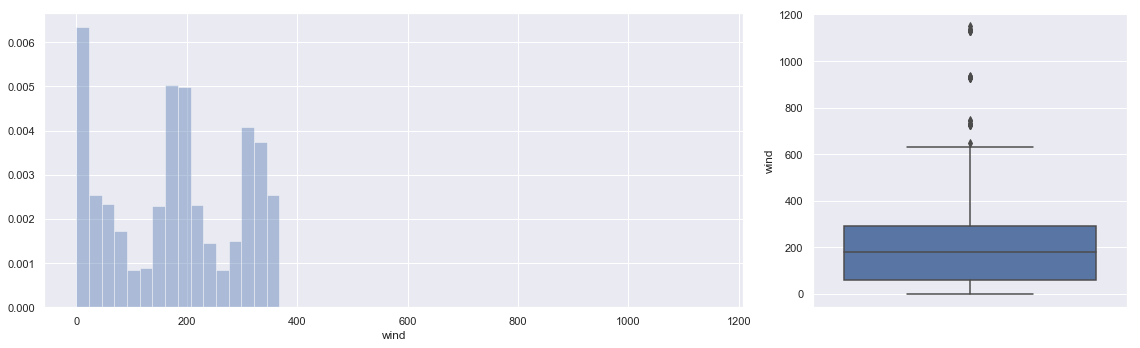

0.25 quantile:  60.0
0.5 quantile:  180.0
0.75 quantile:  290.0
0.95 quantile:  350.0
0.99 quantile:  360.0
max value: 1150


In [76]:
f.distribution_check(df_weather, 'wind')

In [77]:
df_weather = df_weather[df_weather['wind']<400]

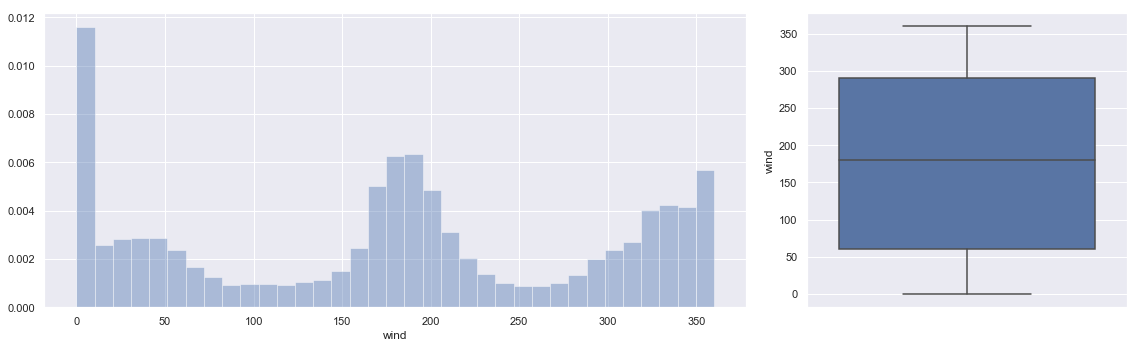

0.25 quantile:  60.0
0.5 quantile:  180.0
0.75 quantile:  290.0
0.95 quantile:  350.0
0.99 quantile:  360.0
max value: 360


In [78]:
f.distribution_check(df_weather, 'wind')

## Distribution of relative humidity and pressure

Both relative humidity and pressure distribution look properly. Relative humidity ranges from 0 to 1 which is correct and records for atmospheric pressure range from 870 hPa to 1084.8 hPa which are also right bounds.

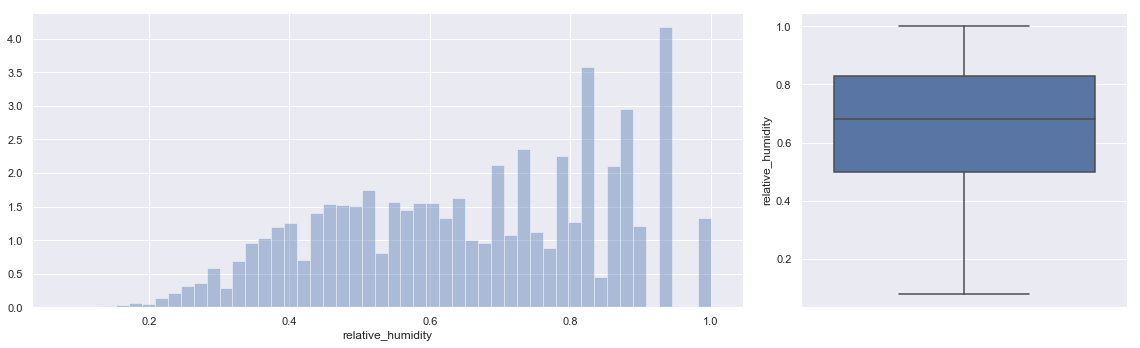

0.25 quantile:  0.5
0.5 quantile:  0.68
0.75 quantile:  0.83
0.95 quantile:  0.94
0.99 quantile:  1.0
max value: 1.0


In [79]:
f.distribution_check(df_weather, 'relative_humidity')

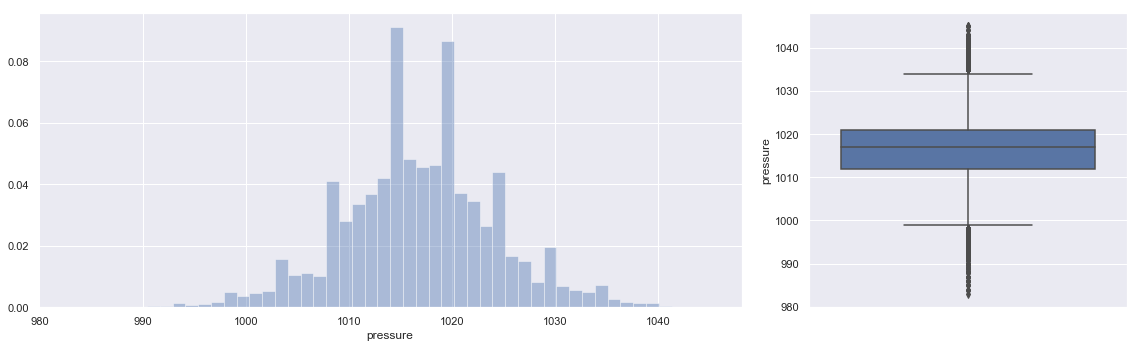

0.25 quantile:  1012.0
0.5 quantile:  1017.0
0.75 quantile:  1021.0
0.95 quantile:  1030.0
0.99 quantile:  1035.0
max value: 1045


In [80]:
f.distribution_check(df_weather, 'pressure')

## Summary

1. Data obtained from Capital Bike Share are very clean and they don't require removing any records.
2. As a consequence of two different patterns in behaviour of bike users, all rides were divided into two groups: normal and long rides (remove distance and speed for long rides).
3. When it comes to location of stations, used data refer to the specific point in time so there are some records when the location is incorrect. In order to avoid analysis on incorrect data, information about distance and speed was removed from:
    * records from 7 stations,
    * records from several days,
    * records with speed higher than 40 km/h
4. Weather data contain some incorrect records that were entirely removed:
    * one record based on temperature feature
    * records with wind speed higher than 400 km/h